In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

In [ ]:
DATAFOLDER = Path("..\\data")
FIGSFOLDER = Path("..\\figures")
FIGSFOLDER = Path("C:\\Users\\jmc010\\Dropbox\\Publications in Progress\\IPP Giulia paper\\figs")

def tweak_df(df):

    return (df
            .query("session == 's4'")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

## Panel A

In [29]:
def get_licks_per_solution(row):
    filename = row.medfile
    # print(f"Processing {filename}")

    L, R = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "e"], remove_var_header=True)

    if "malt" in row.bottleL and "cas" in row.bottleR:
        med_var_malt, med_var_casein = L, R
    elif "malt" in row.bottleR and "cas" in row.bottleL:
        med_var_malt, med_var_casein = R, L
    else:
        raise ValueError("Bottles not found")
    
    return med_var_casein, med_var_malt

In [31]:
PR_cas, PR_malt = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas.append(len(cas_licks))
    PR_malt.append(len(malt_licks))

NR_cas, NR_malt = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas.append(len(cas_licks))
    NR_malt.append(len(malt_licks))

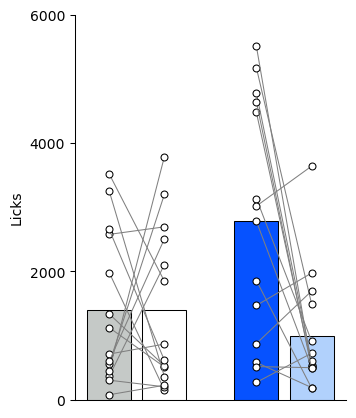

In [66]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(3.5, 5))
tp.barscatter([[NR_cas, NR_malt], [PR_cas, PR_malt],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=50
            );

ax.set_yticks([0, 2000, 4000, 6000])

f.savefig(FIGSFOLDER / "1A_licks_per_solution.pdf", dpi=300)


### Panel B

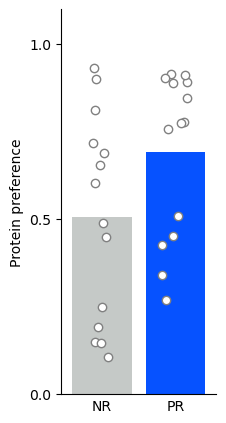

In [ ]:
np.random.seed(41)

def jitter(x, n, spread=0.1):
    return x + np.random.normal(0, spread, n)

PR_pref = np.array(PR_cas) / (np.array(PR_cas) + np.array(PR_malt))
NR_pref = np.array(NR_cas) / (np.array(NR_cas) + np.array(NR_malt))

f, ax = plt.subplots(figsize=(2, 5))

ax.bar( 0, np.mean(NR_pref), color=colors[0])
ax.bar( 1, np.mean(PR_pref), color=colors[2])

ax.scatter(jitter(0, len(NR_pref)), NR_pref, color="white", edgecolor="grey")
ax.scatter(jitter(1, len(PR_pref)), PR_pref, color="white", edgecolor="grey")

ax.set_ylim(0, 1.1)
ax.set_xlim(-0.55, 1.55)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 1], labels=["NR", "PR"])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x', which='both', length=0)

ax.set_ylabel("Protein preference")

f.savefig(FIGSFOLDER / "1B_protein_preference.pdf", dpi=300)

### Panels C and D

In [72]:
def make_protein_pref_heatmap(casein_licks, malt_licks, bins):

    casein_hist = np.histogram(casein_licks, bins=bins)[0]
    malt_lickdata = np.histogram(malt_licks, bins=bins)[0]

    casein_cumsum = np.cumsum(casein_hist)
    malt_cumsum = np.cumsum(malt_lickdata)

    preference_cumsum = []
    for casbin, maltbin in zip(casein_cumsum, malt_cumsum):
        preference_cumsum.append(casbin/(maltbin+casbin))

    return preference_cumsum

def get_heatmap_data_from_row(row, **kwargs):
    
    casein_licks, malt_licks = get_licks_per_solution(row)

    if "bins" in kwargs:
        bins = kwargs["bins"]
    else:
        bins = np.linspace(0,3600, 13)
    
    data = make_protein_pref_heatmap(casein_licks, malt_licks, bins)

    return data

# get_heatmap_data_from_row(df.iloc[0], bins=np.linspace(0,3600, 61))

In [ ]:
bins=np.linspace(0,3600, 13)

PR_data = []
for row in df.query("dietgroup == 'PR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    PR_data.append(data)

NR_data = []
for row in df.query("dietgroup == 'NR'").iterrows():
    data = get_heatmap_data_from_row(row[1], bins=bins)
    NR_data.append(data)


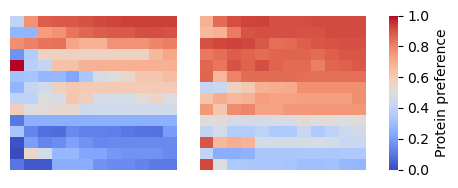

In [116]:
def sort_by_last_value(data):
    data = np.array(data)
    return data[np.argsort(data[:, -1])]

PR_data_to_plot = sort_by_last_value(PR_data)
NR_data_to_plot = sort_by_last_value(NR_data)

def make_heatmap_fig(data, ax, cbar_ax=False, show_x_axis=True, **kwargs):
    
    if cbar_ax:
        sns.heatmap(data, ax=ax,
                    cmap="coolwarm",
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax
                    )
        
            # Rotate the colorbar label
        # cbar = cbar_ax.collections[0].colorbar
        # cbar.set_label('Protein preference', rotation=270, labelpad=15)
        
        ax3.set_ylabel('Protein preference')
        
    else:
        sns.heatmap(data, ax=ax,
                cmap="coolwarm",
                vmin=0, vmax=1,
                cbar=False
                )



    ax.invert_yaxis()
    ax.set_yticks([])

    ticks = np.linspace(0, data.shape[1], 7)
    
    if show_x_axis:

        ax.set_xticks(ticks,
                    labels=[0, 10, 20, 30, 40, 50, 60],
                    rotation=0)
        ax.set_xlabel("Time (min)")
        
    else:
        ax.set_xticks([])

f, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(5,2),
                                  gridspec_kw={"width_ratios": [1, 1, 0.05]}
                                  )

make_heatmap_fig(NR_data_to_plot, ax1, cbar_ax=False, show_x_axis=False)
make_heatmap_fig(PR_data_to_plot, ax2, cbar_ax=ax3, show_x_axis=False)

f.savefig(FIGSFOLDER / "heatmaps.pdf", dpi=300)

### Panels E and F

In [92]:
def get_cumsum_licks(licks, bins=np.linspace(0, 3600, 61)):
    hist = np.histogram(licks, bins=bins)[0]
    return np.cumsum(hist)

bins=np.linspace(0, 3600, 61)

PR_cas, PR_malt = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas.append(get_cumsum_licks(cas_licks))
    PR_malt.append(get_cumsum_licks(malt_licks))

NR_cas, NR_malt = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas.append(get_cumsum_licks(cas_licks))
    NR_malt.append(get_cumsum_licks(malt_licks))
    
PR_cas = np.array(PR_cas)
PR_malt = np.array(PR_malt)
NR_cas = np.array(NR_cas)
NR_malt = np.array(NR_malt)

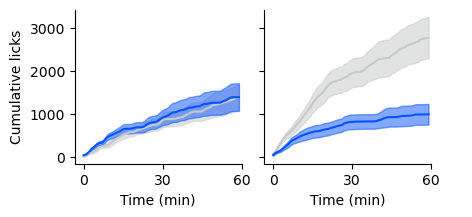

In [119]:
def make_cumsum_fig(cas_licks, malt_licks, bins, colors, ax):
    
    cas_sem = np.std(cas_licks, axis=0) / np.sqrt(cas_licks.shape[0])
    malt_sem = np.std(malt_licks, axis=0) / np.sqrt(malt_licks.shape[0])
    
    ax.fill_between(bins[:-1], np.mean(cas_licks, axis=0)-cas_sem, np.mean(cas_licks, axis=0)+cas_sem, color=colors[0], alpha=0.5)
    ax.plot(bins[:-1], np.mean(cas_licks, axis=0), color=colors[0], label="Casein")

    ax.fill_between(bins[:-1], np.mean(malt_licks, axis=0)-malt_sem, np.mean(malt_licks, axis=0)+malt_sem, color=colors[2], alpha=0.5)
    ax.plot(bins[:-1], np.mean(malt_licks, axis=0), color=colors[2], label="Maltodextrin")
    
    

f, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(5,2),
                                  sharey=True,
                                  gridspec_kw={"width_ratios": [1, 1, 0.05]}
                                  )

make_cumsum_fig(NR_cas, NR_malt, bins, colors, ax1)
make_cumsum_fig(PR_cas, PR_malt, bins, colors, ax2)

for ax in [ax1, ax2]:
    ax.set_xlim(-200, 3600)
    ax.set_xticks([0, 1800, 3600], labels=[0, 30, 60])
    ax.set_xlabel("Time (min)")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax1.set_ylabel("Cumulative licks")

ax3.axis("off")

f.savefig(FIGSFOLDER / "cumulative_licks.pdf", dpi=300)
